# Soft K-means
## Load data and plot it

Cluster1: (30L, 2L), Cluster2: (30L, 2L)


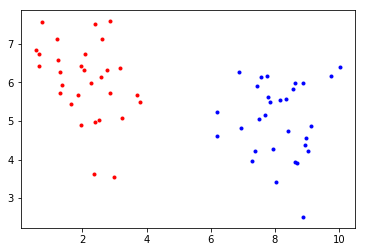

In [1]:
import numpy as np
import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt

# Load synthetic data [dataset1.mat, dataset2.mat, dataset3.mat]
data = sio.loadmat('datasets/dataset1.mat')

data1_true = np.array(data['x'].T)
data2_true = np.array(data['y'].T)
print("Cluster1: {}, Cluster2: {}".format(data1_true.shape, data2_true.shape))

# Plot the data with true cluster label
plt.scatter(data1_true[:, 0], data1_true[:, 1], c='r', marker='.');
plt.scatter(data2_true[:, 0], data2_true[:, 1], c='b', marker='.');

## Define function for K-means

In [2]:
def get_distance_matrix(data, centers):
    """
    Get distance matrix between each point in matrix 'data' and
    each point in matrix 'centers'
    
    Args:
        data: 2D-matrix of shape (N * D) where N is the number of data and D is the dimension of data
        centers: 2D_matrix of shape (K * D) where K is the number of clusters
    Returns:
        distance_mat: computed distance matrix of shape (N * K)
    """
    
    # Define N, D and K using the discription above with np.shape function
    N, D = data.shape
    K = centers.shape[0]
    
    # Initialize distance matrix with zeros
    distance_mat = np.zeros((N, K))
    
    # Update distance matrix
    for k in range(K):
        distance_mat[:, k] = np.sqrt(np.sum((data - centers[k]) ** 2, axis=1))
    
    return distance_mat

def get_new_centers(data, K, predicted_cluster):
    """
    Get new centers
    
    Args:
        data: 2D-matrix of shape (N * D) where N is the number of data and D is the dimension of data
        K: the number of clusters
        predicted_cluster: a vector of shape (N) that has elements assigned cluster for each data point
    Returns:
        new_centers: new center matrix of shape (K * D)
    """
    
    # Define python list
    new_centers = []
    
    # For each center
    for k in range(K):
        # Find which data point belongs to the cluster k
        cluster_index = predicted_cluster == k
        x_k = data[cluster_index]
        
        # Compute the new mean from thoes data
        new_center = np.mean(x_k, axis=0)
        
        # Append the new center to the python list new_centers
        new_centers.append(new_center)
    
    return np.array(new_centers)

## Train

In [3]:
# Merge the data to one matrix
data = np.vstack((data1_true, data2_true))

K = 2
N = data.shape[0]

# Initialize centers with K randomly selected data
permu = np.random.permutation(len(data))
centers = data[permu[:K]]
# Initialize responsibilities
resp = np.zeros((N, K))

beta = 0.001
max_iter = 2000
for step in range(max_iter):
    # Assign
    x_minus_mu = np.expand_dims(data, 1) - np.expand_dims(centers, 0)
    numerator = np.exp(-beta * np.sum(x_minus_mu ** 2, 2))
    resp = numerator / np.sum(numerator, 1, keepdims=True)
    # Update
    centers = (np.matmul(data.T, resp)/ np.sum(resp, 0, keepdims=True)).T

predicted_cluster = np.argmax(resp, axis=1)

## Compare true clusters and predicted clusters

Prediction | Cluster1: (60L, 2L), Cluster2: (0L, 2L)
True       | Cluster1: (30L, 2L), Cluster2: (30L, 2L)


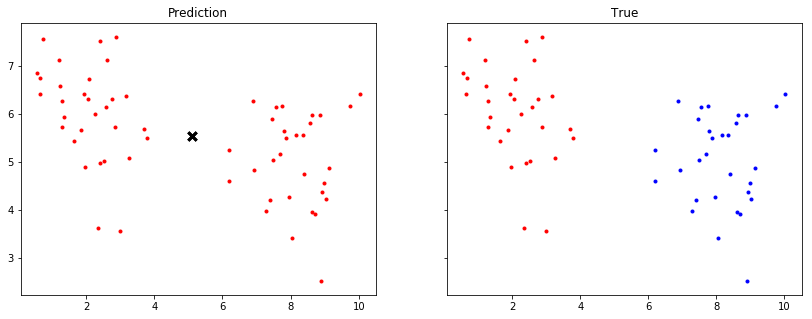

In [4]:
data1 = data[predicted_cluster == 0]
data2 = data[predicted_cluster == 1]
print("Prediction | Cluster1: {}, Cluster2: {}".format(data1.shape, data2.shape))
print("True       | Cluster1: {}, Cluster2: {}".format(data1_true.shape, data2_true.shape))

# Plot the data and compare it with true labeled data
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(14, 5))
axarr[0].scatter(centers[0, 0], centers[0, 1], c='k', marker='x', s=70, linewidth=3);
axarr[0].scatter(centers[1, 0], centers[1, 1], c='k', marker='x', s=70, linewidth=3);
axarr[0].scatter(data1[:, 0], data1[:, 1], c='r', marker='.');
axarr[0].scatter(data2[:, 0], data2[:, 1], c='b', marker='.');
axarr[0].set_title('Prediction');
axarr[1].scatter(data1_true[:, 0], data1_true[:, 1], c='r', marker='.');
axarr[1].scatter(data2_true[:, 0], data2_true[:, 1], c='b', marker='.');
axarr[1].set_title('True');

## Evaluate how well K-means clustered data

In [5]:
# Evaluate clustering performance using Normalized Mutual Information
def get_NMI(true_cluster, predicted_cluster, K):
    """
    Get Normalized Mutual Information
    
    Args:
        true_cluster: a vector of shape (N) that has elements assigned true cluster for each data point
        predicted_cluster: a vector of shape (N) that has elements assigned predicted cluster for each data point
        K: the number of clusters
    Returns:
        nmi: Normalized mutual information
    """
    # very little value to prevent logarithm from -infinity
    eps = 1e-10
    
    # Define the number of data
    N = float(data.shape[0])
    
    true_entropy = 0
    predicted_entropy = 0
    # Compute entropy for ground truth clusters and predicted clusters
    for k in range(K):
        true_ctr = np.sum(true_cluster == k)
        predicted_ctr = np.sum(predicted_cluster == k)
        true_entropy += -(true_ctr / N) * np.log2(true_ctr / N + eps)
        predicted_entropy += -(predicted_ctr / N) * np.log2(predicted_ctr / N + eps)
    
    denominator = (true_entropy + predicted_entropy) / 2.
    
    mi = 0
    # Compute mutual information between ground truth clusters and predicted clusters
    for i in range(K):
        for j in range(K):
            true_k = true_cluster == i
            predicted_k = predicted_cluster == j
            inter_ctr = np.sum(true_k & predicted_k)
            true_ctr = np.sum(true_k)
            predicted_ctr = np.sum(predicted_k)
            mi += (inter_ctr / N) * np.log2((N * inter_ctr) / (true_ctr * predicted_ctr) + eps)
    
    nmi = mi / denominator
    
    return nmi

true_cluster = np.concatenate((np.zeros(data1_true.shape[0]), np.ones(data2_true.shape[0])))
nmi = get_NMI(true_cluster, predicted_cluster, K)
print("Nomrlized Mutual Information: {}".format(nmi))

ZeroDivisionError: float division by zero